In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import time
import numpy as np
from matplotlib import pyplot as plt
data_dir = './data/cinic-10_image_classification_challenge-dataset'
from tensorflow.keras.regularizers import l1_l2
input_shape = (32, 32, 3)

# load data

In [31]:
def load_and_preprocess_image(image_path, label):
    # Load image
    image = tf.io.read_file(image_path)
    # Decode PNG image to tensor
    image = tf.image.decode_png(image, channels=3)  # Adjust channels according to your images
    # Normalize pixel values to range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label


def preprocess_data():
    data_dir = './data/cinic-10_image_classification_challenge-dataset'

    class_names = os.listdir(data_dir + '/train/')
    label_dict = {i : label for i, label in enumerate(os.listdir(data_dir + '/train/'))}

    image_paths = []
    labels = []
    train_dir = data_dir + '/train/'
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            labels.append(class_names.index(class_name))

    # Create TensorFlow Dataset from the loaded data
    train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    train_dataset = train_dataset.map(load_and_preprocess_image)

    test_dir = data_dir + '/test/'
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            labels.append(class_names.index(class_name))

    # Create TensorFlow Dataset from the loaded data
    test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    test_dataset = test_dataset.map(load_and_preprocess_image)

    dataset = train_dataset.shuffle(buffer_size=10000)

# Split the dataset into train, validation, and test sets
    train_size = int(0.8 * len(dataset))
    val_size = int(0.2 * len(dataset))

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(32)
    val_dataset = val_dataset.shuffle(buffer_size=len(image_paths)).batch(32)
    test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(32)
    return train_dataset, val_dataset, test_dataset

label_dict = {i : label for i, label in enumerate(os.listdir(data_dir + '/train/'))}

# pre-made dataset from cifar dataset

In [32]:
train_dataset, val_dataset, test_dataset = preprocess_data()

# CNN definition

In [33]:
def cnn(input_shape, elastic_net = False, l1 = 0.01, l2 = 0.01):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer = l1_l2(l1, l2))) # output shape is 30x30x32
    model.add(layers.MaxPooling2D((2, 2))) # output shape is 15x15x32
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = l1_l2(l1, l2)) ) # output shape is 13x13x64
    model.add(layers.MaxPooling2D((2, 2))) # output shape is 6x6x64
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = l1_l2(l1, l2)) ) #4x4x64

    # Dense layer
    model.add(layers.Flatten()) # 1024
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

### searching for elastic net regularizer
grid search, because there's two parameters - l1 and l2

In [34]:
histories = {}
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
l1_range = np.linspace(0, 1, 10)  # Example: 10 values between 0 and 1
l2_range = np.linspace(0, 1, 10)  # Example: 10 values between 0 and 1

# Generate candidate combinations using grid search
search_space = [(l1, l2) for l1 in l1_range for l2 in l2_range]
for l1, l2 in search_space:
    model = cnn(input_shape, True, l1, l2)
    model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    history = model.fit(train_dataset, epochs = 3, validation_data = val_dataset)    
    test_loss, test_acc = model.evaluate(test_dataset)
    histories[(l1, l2)] = {'history': history.history,
                        'test_loss': test_loss,
                        'test_acc': test_acc}

Epoch 1/3


2247/2250 [============================>.] - ETA: 0s - loss: 1.5761 - accuracy: 0.4153

In [24]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

Epoch 1/30


2250/2250 [==============================] - 31s 13ms/step - loss: 0.5060 - accuracy: 0.8172 - val_loss: 1.1328 - val_accuracy: 0.6058
Epoch 2/30
2250/2250 [==============================] - 32s 14ms/step - loss: 0.4919 - accuracy: 0.8218 - val_loss: 0.9358 - val_accuracy: 0.6945
Epoch 3/30
2250/2250 [==============================] - 32s 14ms/step - loss: 0.4777 - accuracy: 0.8278 - val_loss: 1.1143 - val_accuracy: 0.6285
Epoch 4/30
2250/2250 [==============================] - 32s 14ms/step - loss: 0.4705 - accuracy: 0.8314 - val_loss: 1.1142 - val_accuracy: 0.6506
Epoch 5/30
2250/2250 [==============================] - 31s 13ms/step - loss: 0.4559 - accuracy: 0.8346 - val_loss: 1.0527 - val_accuracy: 0.6574
Epoch 6/30
2250/2250 [==============================] - 31s 14ms/step - loss: 0.4464 - accuracy: 0.8376 - val_loss: 1.1915 - val_accuracy: 0.6466
Epoch 7/30
2250/2250 [==============================] - 32s 14ms/step - loss: 0.4327 - accuracy: 0.8433 - val_loss: 1.3384 - val_accura

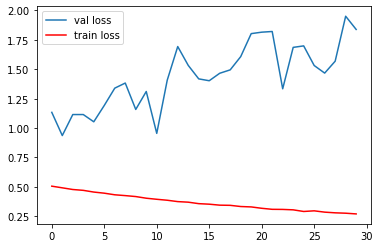

In [49]:
plt.plot(history.history['val_loss'], label = 'val loss')
plt.plot(history.history['loss'], c = 'red', label = 'train loss')
plt.legend()

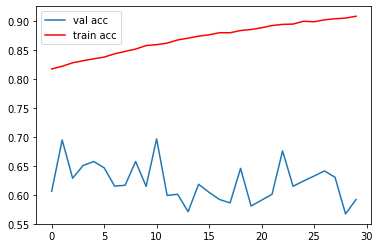

In [50]:
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.plot(history.history['accuracy'], c = 'red', label = 'train acc')
plt.legend()